In [1]:
%%html 
<link href="https://fonts.googleapis.com/css?family=Open+Sans" rel="stylesheet">
<style>#notebook-container{font-size: 13pt;font-family:'Open Sans', sans-serif;} div.text_cell{max-width: 104ex;}</style>

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
from sklearn.model_selection import train_test_split

# Decision Trees

Decision trees are widely used models for classification and regression tasks. Essentially, they learn a hierarchy of if/else questions, leading to a decision.

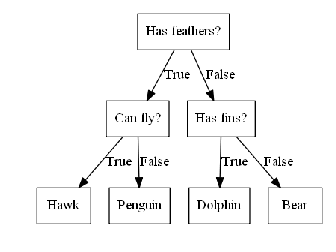

In [4]:
mglearn.plots.plot_animal_tree()

## Controlling complexity of decision trees

We can run the algorithm until all the leaves of the graph are pure. Which means that the model will have an accuracy of 100% on the training data. This tends to very complex models.

There are two common strategies to prevent overfitting: stopping the creation of the tree early (_pre-pruning_), or building the three but then removing or collapsing nodes that contain little information (_post-pruning_, or just _pruning_).

Decision trees are implemented in the `DecisionTreeRegressor` and `DecisionTreeClassifier` classes in `scikit-learn`.

In [5]:
from sklearn.datasets import load_breast_cancer
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.937


The test accuracy is 100% because the leaves are pure. The test set accuracy is slightly worse that for the linear models, which had around 95% accuracy.

If we don't restrict the depth of a decision tree, the tree can become arbitrarily deep and complex. Unpruned trees are therefore prone to overfitting and not generalizing well to new data. One option is to stop building the tree after a certain depth has been reached.

In [6]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)
print('Accuracy on training set: {:.3f}'.format(tree.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(tree.score(X_test, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.951


## Analyzing decision trees

We can visualize the tree using the `export_graphviz` function from the `tree` module.

In [7]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignant", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

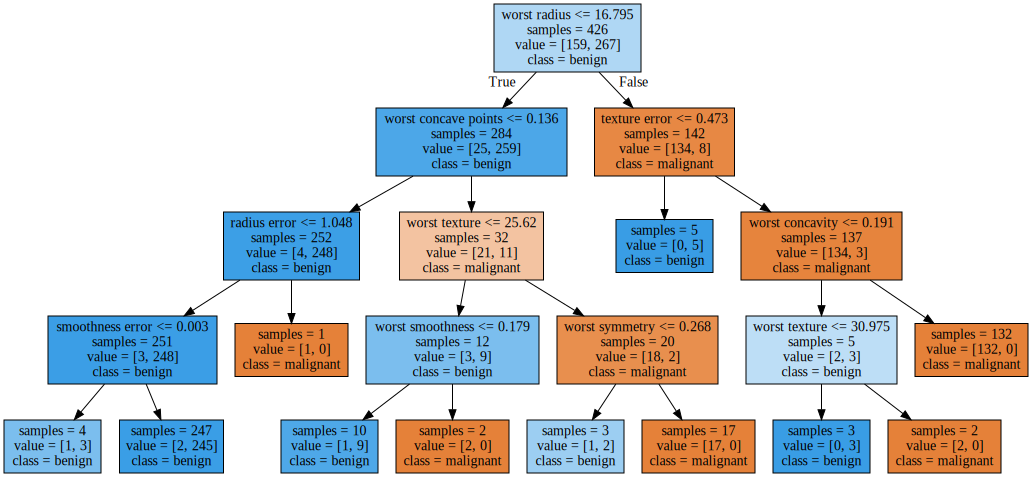

In [8]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

The visualization of the tree provides a great in-depth view of how the algorithm makes predictions, and is a good example of a machine learning algorithm.

## Feature importance in trees

Instead of looking at the whole tree, there are some useful properties that we can derive to summarize the workings of the tree. The most commonly used summary is _feature importance_, which rates how important each feature is for the decision a tree makes.

In [9]:
print("Feature importance:\n{}".format(tree.feature_importances_))

Feature importance:
[ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.01019737  0.04839825  0.          0.
  0.0024156   0.          0.          0.          0.          0.
  0.72682851  0.0458159   0.          0.          0.0141577   0.          0.018188
  0.1221132   0.01188548  0.        ]


We can visualize the feature importances in a way that is similar to the way we visualize the coefficients in the linear model.

In [10]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.figure(figsize=(10,8))
    plt.barh(range(n_features), model.feature_importances_, align='center', facecolor='b', alpha=0.4)
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

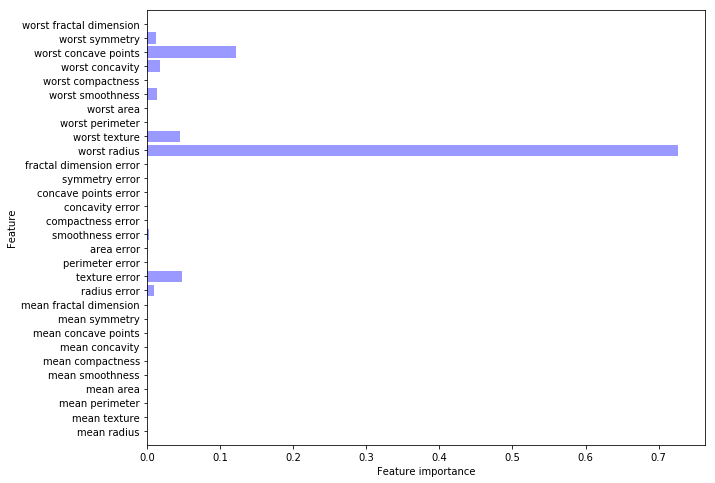

In [11]:
plot_feature_importances_cancer(tree)

If a feature has a low value in `feature_importances_`, it doesn't mean that this feature is uninformative. It only means that the feature was not picked by the tree, likely because another feature encodes the same information.

Feature importances: [ 0.  1.]


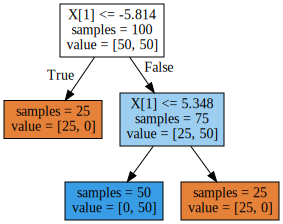

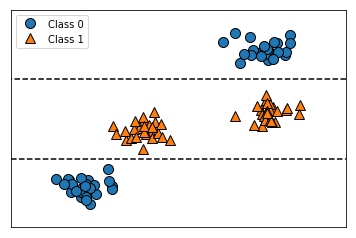

In [12]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

## Decision Tree Regressor

All that we have said for decision trees for classification is similarly true for decision trees for regression. This is implemented in the `DecisionTreeRegressor` class.

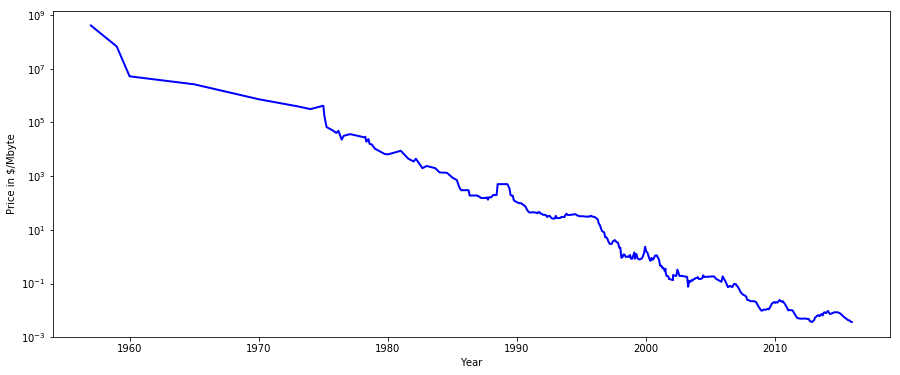

In [13]:
import os
ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"))

plt.figure(figsize=(15,6))
plt.semilogy(ram_prices.date, ram_prices.price, c='b', lw=2)
plt.xlabel("Year")
plt.ylabel("Price in $/Mbyte");

Note the logarithmic scale of the y-axis. When plotting logarithmically, the relation seems to be quite linear and so should be relatively easy to predict, apart from some bumps.

The `DecisionTreeRegressor` (and other tree-based regression models) is not able to _extrapolate_, or make prediction outside of the range of the training data.

In [14]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

X_train = data_train.date[:, np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

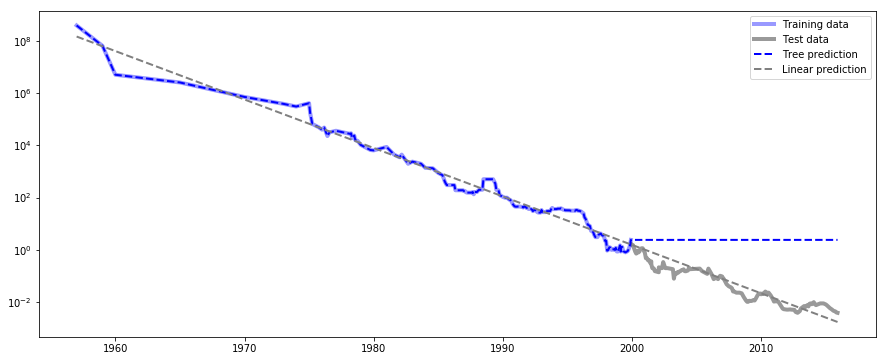

In [15]:
plt.figure(figsize=(15, 6))
plt.semilogy(data_train.date, data_train.price, label="Training data", c='b', lw=4, alpha=0.4)
plt.semilogy(data_test.date, data_test.price, label="Test data", c='black', lw=4, alpha=0.4)
plt.semilogy(ram_prices.date, price_tree, label="Tree prediction", c='b', linestyle='--', lw=2)
plt.semilogy(ram_prices.date, price_lr, label="Linear prediction", c='gray', linestyle='--', lw=2)
plt.legend();

## Parameters

The parameters that control model complexity in decision trees are the pre-pruning parameters that stop the building of the tree before it is fully developed. Usually, picking one of the pre-pruning strategies -- setting either `max_depth`, `max_leaf_nodes`, or `min_samples_leaf` -- is sufficient to prevent overfitting.

## Strengths

Decision trees have two advantages over many of the algorithms we've discussed so far: the resulting model can easily be visualized and understood by non-experts, and the algorithms are completely invariant to scaling of data. In particular, decision trees work well when you have features that are on completely different scales, or a mix of binary and continous features.

## Weaknesses

The main downside of decision trees is that even with use of pre-pruning, they tend to overfit and provide poor generalization performance. Therefore, in most applications, the ensemble methods we duscuss next are usually used in place of a single decision tree.